Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import numpy as np
import requests
from keras.callbacks import History 
history = History()
API_KEY = 'ei_b72f76a9bc8e9358c39a734b4d42686d322e6eb28c6d6d6cbd5085b163b63304'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/86682/training/48/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/86682/training/48/y')


2022-03-15 12:24:22.890206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 12:24:22.890259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Store the data in a temporary file, and load it back through Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [3]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "Fire", "Noise" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


2022-03-15 12:24:41.489017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-15 12:24:41.489070: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 12:24:41.489105: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PC-Matt): /proc/driver/nvidia/version does not exist
2022-03-15 12:24:41.489500: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the model:

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 65), 65), input_shape=(input_length, )))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.3))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False


Epoch 1/50
111/111 - 1s - loss: 0.4474 - accuracy: 0.7819 - val_loss: 0.3000 - val_accuracy: 0.8657 - 700ms/epoch - 6ms/step
Epoch 2/50
111/111 - 0s - loss: 0.3088 - accuracy: 0.8718 - val_loss: 0.2564 - val_accuracy: 0.9007 - 192ms/epoch - 2ms/step
Epoch 3/50
111/111 - 0s - loss: 0.2759 - accuracy: 0.8898 - val_loss: 0.2300 - val_accuracy: 0.9097 - 195ms/epoch - 2ms/step
Epoch 4/50
111/111 - 0s - loss: 0.2437 - accuracy: 0.9071 - val_loss: 0.2166 - val_accuracy: 0.9255 - 199ms/epoch - 2ms/step
Epoch 5/50
111/111 - 0s - loss: 0.2182 - accuracy: 0.9130 - val_loss: 0.1836 - val_accuracy: 0.9368 - 202ms/epoch - 2ms/step
Epoch 6/50
111/111 - 0s - loss: 0.2235 - accuracy: 0.9164 - val_loss: 0.2020 - val_accuracy: 0.9323 - 223ms/epoch - 2ms/step
Epoch 7/50
111/111 - 0s - loss: 0.2050 - accuracy: 0.9257 - val_loss: 0.1731 - val_accuracy: 0.9413 - 205ms/epoch - 2ms/step
Epoch 8/50
111/111 - 0s - loss: 0.2169 - accuracy: 0.9155 - val_loss: 0.1871 - val_accuracy: 0.9368 - 194ms/epoch - 2ms/step


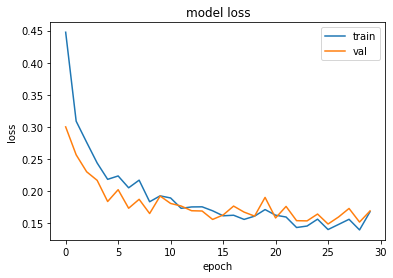

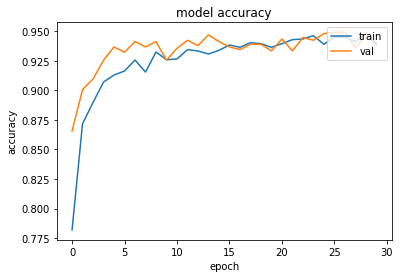

In [5]:
import keras
from matplotlib import pyplot as plt

loss=history.history['loss']
loss=loss[:30]
plt.plot(loss)
val_loss=history.history['val_loss']
val_loss=val_loss[:30]
plt.plot(val_loss)



plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

acc=history.history['accuracy']
acc=acc[:30]
plt.plot(acc)
vacc=history.history['val_accuracy']
vacc=vacc[:30]
plt.plot(vacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()